In [1]:
import os
import json, re
#import numpy as np
import time, datetime, pytz

tz = pytz.timezone('Asia/Singapore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from solver.corpora import Thesaurus
#thesaurus = Thesaurus()

In [4]:
from solver.corpora import CrosswordQA
crossword_qa = CrosswordQA()

Loading combined tsv took 11.2s


In [5]:
print(f"{len(crossword_qa.combined)=}")
print(f"{crossword_qa.combined['flirt']=}")
#print(f"{crossword_qa.combined['FLIRT']=}")  # Key error

len(crossword_qa.combined)=4493721
crossword_qa.combined['flirt']={'OGLER', 'TOYER', 'WINKER', 'CARRY ON', 'WINK', 'DALLY', 'TOY', 'COQUETTE', 'LADIESMAN', 'TEASE', 'MASH', 'GIVESOMEONETHEI', 'VAMP', 'CARRYON', 'EYER', 'MINNX', 'MINX', 'OGLE', 'TTTTT', 'COQUET', 'PITCH A LITTLE WOO', 'GIVESOMEONE THEI', 'PHILANDER', 'PITCHALITTLEWOO', 'LADIES MAN'}


In [6]:
print(f"{crossword_qa.is_synonym('flirt','TEASE')}")

True


In [7]:
from solver.corpora import Abbreviations
abbreviations=Abbreviations()

In [8]:
from solver.corpora import VectorEmbedder
embedder = None # Free up memory
embedder = VectorEmbedder()  # May take a while...

Loaded ./cc.en.100.bin


In [33]:
from solver.corpora import Actions
actions=Actions(embedder=embedder)  # Includes building ~2000 embeddings : Super quick!
#print(actions.action_to_phrase['HOMOPHONE'][:4])
print(f"{actions.action_to_phrase['ANAGRAM'][:4]=}")
#Action.HOMOPHONE.name
print(f"{actions.phrase_to_action['briefly'][:4]=}")
print(f"{len(actions.phrase_to_action)=}, {len(actions.action_to_phrase)}")
print(f"{actions.phrase_emb.shape=}")

actions.action_to_phrase['ANAGRAM'][:4]=['abandoned', 'aberrant', 'abnormal', 'about']
actions.phrase_to_action['briefly'][:4]=['REMOVE_LAST']
len(actions.phrase_to_action)=1734, 10
actions.phrase_emb.shape=(1734, 100)


In [35]:
# grep -h 'does not suggest Action.' experiments/wordplay_candidate_0/g2wordplay/000/* | sort | uniq

#action_arr = actions.get_closest_actions('to admit', score_min=0.5, actions_max=5, debug=True)
action_arr = actions.get_closest_actions('talked of', score_min=0.5, actions_max=5, debug=True)
#action_arr = actions.get_closest_actions('goes inside', debug=True)
#action_arr = actions.get_closest_actions('made by', debug=True)
#action_arr = actions.get_closest_actions('variety of', score_min=0.5, actions_max=5, debug=True)
#action_arr = actions.get_closest_actions('tumbled', debug=True)
#action_arr = actions.get_closest_actions('eastern', debug=True)
#action_arr = actions.get_closest_actions('on the radio', debug=True)
action_arr, 'ANAGRAM' in action_arr

  phrase='talked of' score=1.00 match='talked of' ['HOMOPHONE']
  phrase='talked of' score=0.78 match='made of' ['ANAGRAM']
  phrase='talked of' score=0.73 match='talked about' ['HOMOPHONE']
  phrase='talked of' score=0.72 match='start of' ['INITIALS']
  phrase='talked of' score=0.71 match='talked' ['HOMOPHONE']
  phrase='talked of' score=0.71 match='of' ['SUBSTRING']
  phrase='talked of' score=0.70 match='brought about' ['REVERSE']


(['HOMOPHONE', 'ANAGRAM', 'INITIALS', 'SUBSTRING', 'REVERSE'], True)

In [24]:
from solver import Action
Action.ANAGRAM in action_arr

False

In [14]:
#from solver import Action, action_enums
#dir(Action)
#from solver.corpora import Actions
#Actions.enums

In [9]:
from solver.llm import get_model, RetryingLLM, CacheableLLM
base_model = get_model() 
base_model = RetryingLLM( base_model )  # Robustify Gemini Model...

Redis server is available and running.


In [10]:
#from solver.llm import redis_server

In [11]:
solver_config=dict(
  thesaurus=thesaurus,
  abbreviations=abbreviations,
  #model_synonym=CacheableLLM( base_model, ), 
  model_synonym=CacheableLLM( base_model, cache_prefix="SYN_", ), 
  model_homophone=CacheableLLM( base_model, ), 
  #model_homophone=CacheableLLM( base_model, cache_prefix="HOM_", ), 
  actions=actions,
)

In [12]:
from solver import function_defs
from solver import prompts
#print(function_defs)

In [291]:
prompt_parts = [
  '''
The following are functions that can be used in your output code:\n''', 
  function_defs,
  '''
The following are examples of simple functions that prove that each puzzle solution is correct:''', 
  prompts.proof_example('ONCE'),
  prompts.proof_example('DECIMAL'),
  prompts.proof_example('RELIABLE'),
  prompts.proof_example('DELINEATE'),
  prompts.proof_example('SUPERMARKET'),
  f'''
# Please complete the following in a similar manner, and return the whole function:
```python
def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {{optical device}}
  wordplay: ''', 

#def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
#  """
#  definition: arrived with an artist, to get {{optical device}}
#def proof(answer="DELVE", clue="research done, primarily, on most of magical beings", pattern='5'):
#  """
#  definition: {{research}} done, primarily, on most of magical beings

# research done, primarily, on most of magical beings (5)  
#  Plan:
#  'arrived': wordplay
#  'with an': nil
#  'artist': wordplay
#  'to get': nil
]
#print('\n'.join(prompt_parts))
print('***')
if 1:
  response = base_model.generate_content(prompt_parts)
  print(response.text)

***
```python
def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("artist", "RA")
  assert "CAME"+"RA"=="CAMERA"
proof()
```


### Parse out the returned function to get better warnings
* If we simply run the function, we would only learn about 1 violation at a time...
  * Better to parse out the function itself

In [292]:
f'''
def proof(clue='head decapitated long ago', answer='ONCE', pattern='4'):
  informal_plan="""
  'head': wordplay
  'decapitated': action
  'long ago': definition
  """
  assert( is_synonym('head', 'BONCE') )
  assert( action_type('decapitated', Action.REMOVE_FIRST) && 'BONCE'[1:]=='ONCE' )
  assert( is_synonym('long ago', 'ONCE', pattern=(4,)) )
  return clue, informal_plan, answer
proof()
''';

In [293]:
# ### Let's debug a python output
content=response.text
print(content)

```python
def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("artist", "RA")
  assert "CAME"+"RA"=="CAMERA"
proof()
```


In [294]:
py = content.strip()
def strip_str(whole, s):
  if whole.startswith(s): whole=whole[len(s):]
  if whole.endswith(s):   whole=whole[:-len(s)]
  return whole
py = strip_str(py, '```python\n')
py = strip_str(py, 'proof()\n```')
print(py)

def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("artist", "RA")
  assert "CAME"+"RA"=="CAMERA"



In [295]:
import ast
parsed = ast.parse(py)

In [296]:
comments=ast.get_docstring(parsed)
comments == None # No surrounding comments

#print(ast.dump(parsed, indent=2))
fn = parsed.body[0] 
if isinstance(fn, (ast.FunctionDef,)) and fn.name=='proof':
  print('def proof(...) found')

print(ast.dump(fn, indent=2)[:200])

def proof(...) found
FunctionDef(
  name='proof',
  args=arguments(
    posonlyargs=[],
    args=[
      arg(arg='answer'),
      arg(arg='clue'),
      arg(arg='pattern')],
    kwonlyargs=[],
    kw_defaults=[],
    defa


In [297]:
assertions=[]

for node in fn.body:  # This is a list of stuff
  #print(ast.dump(node, indent=2))
  if isinstance(node, ast.Expr):
    if isinstance(node.value, ast.Constant):
      print(f"Constant: {node.value.value}")
      continue
  if isinstance(node, ast.Assert):
    #print(f"Assertion: {ast.dump(node.test, indent=2)}")
    src=ast.get_source_segment(py, node.test)
    print(f"Assertion: {src}")
    assertions.append(src)
    continue
  print("Non-conforming line...")
print("\n\nASSERTIONS\n  "+'\n  '.join(assertions))

Constant: 
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (artist) 
  
Assertion: is_synonym("optical device", "CAMERA", pattern='6')
Assertion: is_synonym("arrived", "CAME")
Assertion: is_abbreviation("artist", "RA")
Assertion: "CAME"+"RA"=="CAMERA"


ASSERTIONS
  is_synonym("optical device", "CAMERA", pattern='6')
  is_synonym("arrived", "CAME")
  is_abbreviation("artist", "RA")
  "CAME"+"RA"=="CAMERA"


In [298]:
#def add5(x): return x+5
#eval('add5(2)==6')

In [299]:
if False:
    from enum import Enum #, EnumMeta
    from solver.corpora import Actions
    #Action = Enum('Action', Actions.enums)
    
    # https://stackoverflow.com/a/60375664
    #class ActionValidator(EnumMeta):
    #Action = Enum('Action', Actions.enums, metaclass=ActionValidator)
    
    #class Action(Enum):
    class Action2(object):
      d={}
      def __getattr__(self,  name):
        print(f"Trying to get '{name}'")
        try:
          #return super().__getitem__(name)
        #except (KeyError) as error:
          return Actions.enums.index(name)
        except (ValueError) as error:
        #options = ', '.join(cls._member_map_.keys())
          options = ', '.join(Actions.enums)
          msg = f"'{name}' is invalid, please choose one of {options}"
          raise ValueError(msg) from None
    Action = Action2()
      #pass
      #Enum('Action', Actions.enums)
      #def __new__(cls):
      #  for v, name in enumerate(Actions.enums):
      #    print(f"setting {name}={v}")
      #    cls.name=v 
    print(Actions.enums)
    Action.ANAGRAM, Action.HOMOPHONE, Action.sdsOMOPHONE

In [300]:
#from solver import (
#  is_abbreviation, is_synonym, is_homonym, is_anagram, 
#  action_type, literal,
#)
from solver import SolverState

In [301]:
if True:
  ss=SolverState(**solver_config)
  #ss.eval_assertion("""'CAME'+'RA'=='CAMERA'""") # == True
  #ss.eval_assertion("""'CAM'+'RA'=='CAMERA'""") # == False
  #ss.eval_assertion("""is_synonym('arrived', 'CAME') and literal('CAME')=='CAME'""") # == True
  #ss.eval_assertion("""is_synonym('arrived', 'CAME')""")  # , pattern='5'
  #ss.eval_assertion("""is_synonym('arrived', 'CAM') and literal('CAM')=='CAME'""") # == False
  #ss.eval_assertion("""action_type('worked', Action.ANAGRAM)""") # == True
  #ss.eval_assertion("""action_type('to get', Action.ANAGRAM)""") # == NADA
  #ss.eval_assertion("""action_type('goes crazy', Action.ANAGRAM)""") # == NADA
  #ss.eval_assertion("""action_type('worked', Action.HOMOPHONE)""") # == offers alternative(s)
  ss.eval_assertion("""action_type('worked', Action.HOMONYM)""") # == does not exist : Specialised return
  #ss.eval_assertion("""action_type('to get', Action.ANAGsdM)""") # == Raises genuine error
  #ss.eval_assertion("""is_anagram('CAMERA', 'CAM')""") # == False
  #ss.eval_assertion("""is_abbreviation('an Artist', 'RA')""")
  #ss.eval_assertion("""is_abbreviation('tillery', 'RA')""")
  #ss.eval_assertion("""is_homophone('here', 'hear')""")  # True
  #ss.eval_assertion("""is_homophone('cow', 'hear')""")   # False
  print(ss.debug_when_failed(''))

AssertionError: action_type('worked', Action.HOMONYM) : 'HOMONYM' is invalid, please choose one of ANAGRAM, REMOVE_FIRST, INITIALS, REMOVE_LAST, GOES_INSIDE, GOES_OUTSIDE, REVERSE, SUBSTRING, HOMOPHONE


In [302]:
# Let's go through the assertions above, and see what we get back...
ss=SolverState(**solver_config)
report=[]
for a in assertions:
  ss.trace=[]
  res=ss.eval_assertion(a)
  if not res:
    report.append(ss.debug_when_failed(a))
if len(report)==0:
  print("SUCCESS!")
else:
  print('\n'.join(report))

SUCCESS!


In [303]:
#abbreviations.short_to_phrase['ra']
abbreviations.phrase_to_short['south']

['s']

In [304]:
#thesaurus.refs.get('camera',[]) #  Quite a few integers...
#thesaurus.refs.get('optical device',[]) #  None

#thesaurus.refs.get('came',[]) # None!!!
#thesaurus.refs.get('arrived',[]) # None!!!

#thesaurus.refs.get('come',[]) # Many
#thesaurus.refs.get('arrive',[]) # Many

In [305]:
arr='BLOus ereur qqqhq blOg blg blog'.split(' ')
print(ss.levensthtein_sorted_list('blog', arr)[:])
print(ss.levensthtein_sorted_list('BLOG', arr)[:])

['blog', 'blg', 'blOg', 'BLOus', 'ereur', 'qqqhq']
['BLOus', 'blOg', 'blg', 'blog', 'ereur', 'qqqhq']


In [306]:
from solver import pattern_to_re
for p in ['4', '4,', '2,5', '2-3', ]:
  print( p, pattern_to_re(p) )

4 ^[a-zA-Z]{4}$
4, ^[a-zA-Z]{4}$
2,5 ^[a-zA-Z]{2}\s[a-zA-Z]{5}$
2-3 ^[a-zA-Z]{2}[\-][a-zA-Z]{3}$


In [307]:
print( prompts.answer_to_pattern('ASDr') )
print( prompts.answer_to_pattern('ASD OIWI-IEI UIddI') )
print( prompts.answer_to_pattern('A SD') )

4
3,4-3,5
1,2


In [308]:
prompts.remove_enumeration_from('initially, a series of races encircling trees (2,5)')

'initially, a series of races encircling trees'

In [309]:
prompts.get_potential_definitions('TWOPENCE', 'town regularly unlocked church for a small sum', embedder)

['town regularly unlocked church for a small {sum}',
 'town regularly unlocked church for a {small sum}']

## Bringing functions together

In [310]:
solver_state_hinter=None
#solver_state_hinter=ss  # Add wordplay hints
prompt_base = prompts.get_proof_prompt_part0(solver_state_hinter=solver_state_hinter)
prompt_question = prompts.get_proof_prompt_part1("arrived with an artist, to get {optical device}", answer="CAMERA", solver_state_hinter=solver_state_hinter)
print('\n---PARTSEP---\n'.join(prompt_base + prompt_question))


The task is to produce a formal proof using python code, where the docstring will also include an informal proof as an aid.
The following are functions that can be used in your output code:

---PARTSEP---
```python
Action = Enum('Action', 'ANAGRAM,REMOVE_FIRST,INITIALS,REMOVE_LAST,GOES_INSIDE,GOES_OUTSIDE,REVERSE,SUBSTRING,HOMOPHONE')
# External definitions
def is_synonym(phrase:str, test_synonym:str, pattern:str='') -> bool:
  # Determines whether 'test_synonym' is a reasonable synonym for 'phrase', with letters optionally matching 'pattern'
  return True # defined elsewhere
def is_abbreviation(phrase:str, test_abbreviation:str) -> bool:
  # Determines whether 'test_abbreviation' is a valid abbreviation or short form for 'phrase'
  return True # defined elsewhere
def action_type(phrase:str, action:Action) -> bool:
  # Determines whether 'phrase' might signify the given 'action'
  return True # defined elsewhere
def is_anagram(letters:str, word:str) -> bool:
  # Determines whether 'wo

In [311]:
response = base_model.generate_content(prompt_base + prompt_question)
print(response.text)

```python
def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (an artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("an artist", "RA")
  assert "CAME"+"RA"=="CAMERA"
proof()
```


In [312]:
py = prompts.extract_python_from_response(response.text)
print(py)

def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (an artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("an artist", "RA")
  assert "CAME"+"RA"=="CAMERA"



In [313]:
from solver import SolverState
ss=SolverState(**solver_config)

fn, err = ss.get_function_from_ast(py)
report = ss.get_code_report(py, fn, err)

if len(report)==0:
  print("SUCCESS!")
else:
  print('\n'.join(report))

AssertionError: assert: is_abbreviation('an artist', 'RA') : 'an artist' does not have a valid abbreviation; 'RA' is an abbreviation for : artist, artillery, Royal Artillery, gunners, painter


In [314]:
# Assemble full new prompt:
prompt_fix_errors = prompts.get_proof_prompt_part2(prompt_base, prompt_question, py, report)
print( '\n---PARTSEP---\n'.join(prompt_fix_errors) )


The task is to produce a formal proof using python code, where the docstring will also include an informal proof as an aid.
The following are functions that can be used in your output code:

---PARTSEP---
```python
Action = Enum('Action', 'ANAGRAM,REMOVE_FIRST,INITIALS,REMOVE_LAST,GOES_INSIDE,GOES_OUTSIDE,REVERSE,SUBSTRING,HOMOPHONE')
# External definitions
def is_synonym(phrase:str, test_synonym:str, pattern:str='') -> bool:
  # Determines whether 'test_synonym' is a reasonable synonym for 'phrase', with letters optionally matching 'pattern'
  return True # defined elsewhere
def is_abbreviation(phrase:str, test_abbreviation:str) -> bool:
  # Determines whether 'test_abbreviation' is a valid abbreviation or short form for 'phrase'
  return True # defined elsewhere
def action_type(phrase:str, action:Action) -> bool:
  # Determines whether 'phrase' might signify the given 'action'
  return True # defined elsewhere
def is_anagram(letters:str, word:str) -> bool:
  # Determines whether 'wo

In [315]:
response_fix_errors = base_model.generate_content(prompt_fix_errors)
print(response_fix_errors.text)

```python
def proof(answer="CAMERA", clue="arrived with an artist, to get optical device", pattern='6'):
  """
  definition: arrived with an artist, to get {optical device}
  wordplay: CAME (arrived) + RA (artist) 
  """
  assert is_synonym("optical device", "CAMERA", pattern='6')
  assert is_synonym("arrived", "CAME")
  assert is_abbreviation("artist", "RA")
  assert "CAME"+"RA"=="CAMERA"
proof()
```


In [316]:
py_fix_errors = prompts.extract_python_from_response(response_fix_errors.text)
fn, err = ss.get_function_from_ast(py_fix_errors)
report = ss.get_code_report(py_fix_errors, fn, err)

if len(report)==0:
  print("SUCCESS!")
else:
  print('\n'.join(report))

SUCCESS!


### Check clue hints

In [48]:
from solver import SolverState
ss=SolverState(**solver_config)

In [49]:
ss.get_clue_hints('arrived with an artist, to get optical device')
#ss.get_clue_hints('part of garment could be yellow, we hear')

["'with' : Potential abbreviation: CON",
 "'an' : Potential abbreviations: A I",
 "'artist' : Potential abbreviations: ARA ETTY LELY PRA RA"]

In [50]:
[(k,arr) for k,arr in ss.actions.phrase_to_action.items() if 'hear' in k]

[('at heart', ['SUBSTRING']),
 ('disheartened', ['SUBSTRING']),
 ('heartless', ['SUBSTRING']),
 ('losing heart', ['SUBSTRING']),
 ('according to hearsay', ['HOMOPHONE']),
 ('as we hear', ['HOMOPHONE']),
 ('heard', ['HOMOPHONE']),
 ('hearing', ['HOMOPHONE']),
 ('overheard', ['HOMOPHONE']),
 ('we hear', ['HOMOPHONE'])]

## Bringing all functions together

In [51]:
prompts.iteratively_answer(base_model, solver_config, 
                           "arrived with an artist, to get {optical device}", answer="CAMERA",
                           #"{research} done, primarily, on most of magical beings", answer="DELVE",
                           #wordplay="D[one] (primarily) (most of) ELVE[s] (magical beings)",
                           max_rewrites=2, add_wordplay_hints=False,
                           wordplay_rubric='./wordplay/rubric-and-single-ex.txt',
                          )


#REWRITE#:0:START::
A Cryptic crossword question involves using the words in the given clue to yield an answer that matches the letter pattern.  
The clue will provide a definition of the answer, as well as some 'wordplay' that can also be used to confirm the answer.  
Expert question solvers write informal 'proofs' using a particular format.

For the definition, the original clue is annotated with '{}' to denote where the definition is to be found.
For the wordplay, the following conventions are loosely used:
* The answer is assembled from the letters in CAPS
* Words in brackets show the origins of letters in CAPS, often being synonyms, or short forms 
* Action words are annotated as illustrated:
  + (ETO N)* (*mad = anagram-signifier) = TONE
  + (FO OR)< (<back = reversal-signifier) = ROOF
  + [re]USE (missing = removal-signifier) = USE
* DD is a shorthand for 'Double Definition'

For example:
---
clue: "arrived with an artist, to get optical device (6)"
definition: arrived with an 

-1

## Ready for the main experimental runs

In [54]:
#def load_dataset(split): # train, val, test
#  d=[]
#  with open(f'./data_orig/cryptonite-{split}.jsonl', 'rt') as f:
#    for l in f.readlines():
#      d.append(json.loads(l))
#  return d
#from solver.dataset import load_cryptonite_dataset, get_shuffled_idx
import solver.dataset
data_train = solver.dataset.load_cryptonite_dataset('train')   
"DONE"

'DONE'

In [55]:
shuffled_idx_train = solver.dataset.get_shuffled_idx(data_train, seed=1234)
"DONE", shuffled_idx_train[:5]

('DONE', [411481, 73840, 90496, 331723, 393135])

In [13]:
def log_file_name(name='base', split='train', idx=0, iter=0):  
  pth=f"./experiments/{name}/{split}/{(idx//1000):03d}"
  os.makedirs(pth, exist_ok=True)
  return f'{pth}/{(idx % 1000):03d}_{iter:02d}.log'

In [57]:
def run_experiment(name, data, shuffled_idx, split, samples=1, examples=10):
  experiment_names_1 = '|norewrites|1rewrite|norewrites-manywordplay|1rewrite-manywordplay|'.split('|')
  experiment_names_2 = '|1rewrite-manywordplay-guessdef|'.split('|')
  experiment_names_3 = '|norewrites-manywordplay-usewordplay|1rewrite-manywordplay-usewordplay|5rewrites-manywordplay-usewordplay|'.split('|')
  if not name in experiment_names_1 + experiment_names_2 + experiment_names_3: 
    print(f"Bad experiment name={name}")
    return
  cnt, cnt_all = 0,0
  for iter in range(0, samples):
    for idx in range(0, examples):
      cnt_all+=1
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      if os.path.isfile(log_file):
        cnt+=1
  print(f"Starting with {cnt}/{cnt_all} done")

  cnt_start, pos = cnt, 0
  t0=time.time()
  for iter in range(0, samples):
    for idx in range(0, examples):
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      if os.path.isfile(log_file):
        continue # Skip this one : it's done already
        
      flog = open(log_file, 'w')
      question = data[shuffled_idx[idx]]
      if name in experiment_names_1 + experiment_names_2 + experiment_names_3:
        max_rewrites=0
        if '1rewrite' in name: 
          max_rewrites=1
        if '5rewrites' in name: 
          max_rewrites=5
          
        wordplay_rubric='./wordplay/rubric-and-single-ex.txt'
        if 'manywordplay' in name: 
          wordplay_rubric='./wordplay/manyshot_train.txt'

        clue = prompts.remove_enumeration_from(question['clue'])
        answer = question['answer']
        if 'guessdef' in name: # Pick a random decent bracketing (if asked)
          clues_with_defs = prompts.get_potential_definitions(answer, clue, embedder)
          clues_with_def_idx = random.randrange(len(clues_with_defs))
          #print(answer.upper(), clues_with_defs)
          clue = clues_with_defs[ clues_with_def_idx ]

        wordplay=None
        if 'usewordplay' in name:
          wordplay=question['wordplay']  # Must be there
        
        success_rewrite = prompts.iteratively_answer(base_model, solver_config, 
                                    clue, answer=answer, pattern=question['enumeration'], wordplay=wordplay, 
                                    max_rewrites=max_rewrites, add_wordplay_hints=False, 
                                    wordplay_rubric=wordplay_rubric,
                                    flog=flog)
      # ... other experiment names
      if success_rewrite>=0:
        pos+=1
      flog.close()
      cnt+=1

      cnt_done = cnt-cnt_start
      elapsed  =(time.time()-t0)
      per_iter =elapsed/cnt_done
      remaining=per_iter*(cnt_all-cnt)
      eta_local=datetime.datetime.now(tz)+datetime.timedelta(seconds=remaining)
      print(f"idx.iter={idx:4d}.{iter:02d} : {pos:4d}/{cnt_done: <4d} success={100.*pos/cnt_done:5.2f}% "+
            f"({per_iter:5.2f}s/iter ETA:{eta_local.strftime('%Y-%m-%d %H:%M:%S %Z')})") # Remaining:{remaining:5.0f}s 
  print(f"Done '{log_file}'")

#run_experiment('norewrites', data_train, shuffled_idx_train, 'train', samples=10, examples=100)
#run_experiment('1rewrite', data_train, shuffled_idx_train, 'train', samples=10, examples=100)
#run_experiment('norewrites-manywordplay', data_train, shuffled_idx_train, 'train', samples=10, examples=100)
#run_experiment('1rewrite-manywordplay', data_train, shuffled_idx_train, 'train', samples=10, examples=100)
#run_experiment('1rewrite-manywordplay-guessdef', data_train, shuffled_idx_train, 'train', samples=10, examples=100)
"DONE"

'DONE'

### Now do extra experiments, but with the human wordplay annotations

In [58]:
#import yaml
#def get_wordplay_data_and_shuffle(split):
#  with open(f"./wordplay/fifteensquared/teacow/author_aggregate_{split}.yaml", 'r') as infile:
#    wordplay_loaded = yaml.safe_load(infile)
#  wordplay_clues=wordplay_loaded['clues']
#  for question in wordplay_clues:
#    question['enumeration']=question['pattern']
#  shuffled_idx = get_shuffled_idx(wordplay_clues, seed=1234)
#  return wordplay_clues, shuffled_idx
wordplay_train, shuffled_idx_wordplay_train = solver.dataset.get_wordplay_data_and_shuffle('train')
"DONE", shuffled_idx_wordplay_train[:5]

('DONE', [4967, 1507, 2316, 4112, 1217])

In [59]:
#run_experiment('1rewrite-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train', samples=10, examples=100)
#run_experiment('norewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train', samples=10, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train', samples=10, examples=100)
"DONE"

'DONE'

### Analyse Re-Sampling vs Iterating for different runs

Need to have:
* For all the files in the experiment, look for 'SUCCESS', and store by example and sample
  + Soon : Capture the successful python entry for given example/sample, for dataset creation

Nice to have: 
* Estimate of how long the run took : Have modification times (but what if we restarted?)
  + Maybe get a sorted array of all modification times, find the differences, discard those >1min
  + Sum up remaining differences to get total (... and average) time taken
  + Also look at file sizes vs iterations (and average time taken)


In [260]:
def get_solves_matrix(name, split, rewrite_last_check=None):
  solves=[]
  idx=0
  while True:
    iter, solves_idx=0, []
    while True:
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      if not os.path.isfile(log_file):
        break # We ran out of iters for this idx
      success_rewrite, rewrite_last = -1, -1
      with open(log_file, 'r') as fin:
        for line in fin.readlines():
          if line.startswith('#REWRITE#'):
            if "SUCCESS!" in line:
              # #REWRITE#:3:SUCCESS!
              _, success_rewrite, _ = line.split(':')
              success_rewrite=int(success_rewrite)
            else:
              if "ERROR TRACE ::" in line:
                split_arr = line.split(':')
                # "#REWRITE#:5:ERROR TRACE ::"
                rewrite_last = int(split_arr[1])
      if success_rewrite<0 and rewrite_last_check is not None:
        if rewrite_last!=rewrite_last_check:
          print(f"File incomplete {rewrite_last=} for '{log_file}'")
      solves_idx.append(success_rewrite)
      iter+=1
    if iter==0: 
      break # We didn't find the first file for this idx    
    solves.append(solves_idx)  # at [idx]
    idx+=1
  return solves
solves = get_solves_matrix(name='5rewrites-manywordplay-usewordplay', split='train', rewrite_last_check=5)
len(solves), solves[30] # Seems like problem idx=30 is fairly easy

(100, [-1, 1, -1, 1, 0, -1, 4, 4, 0, 1])

In [69]:
# Let's sum up across all (idx=examples) of 'what max iter to use' vs how many independent samples to take
import numpy as np
def get_scores_counts(solves):
  solves_np = np.array(solves)
  #solves_np.shape # (100, 10)
  iter_max=solves_np.max()
  
  score_counts=np.zeros(shape=(1+iter_max+1, solves_np.shape[1]), dtype=np.float32)
  for iter_level in range(-1, iter_max+1):  # SUCCESS:iter_level:
    for samples in range(1, solves_np.shape[1]+1):  # 1 .. 10 inclusive
      score_counts[iter_level][samples-1] = int(np.sum( solves_np[:,:samples]==iter_level )/samples*10)/10.
  return score_counts
score_counts = get_scores_counts(solves)

In [71]:
#score_counts  # Each row is a different number of rewrites (starting at 0.  Last row is -1==FAIL), each column is cumulative average
# Last column is 
score_counts[:,-1:].flatten() # .sum()=100

array([ 5.7,  3.3,  3.8,  2.8,  2.9,  2. , 79.5], dtype=float32)

In [72]:
solves_np = np.array(solves)
solves_count_per_clue=(solves_np>=0).sum(axis=-1) # Counts of solves for each clue
' '.join([str(cnt) for cnt in sorted(solves_count_per_clue, reverse=True)])  # Easy=10 solves, hard=0

'10 10 10 9 9 8 7 7 6 6 6 6 5 5 5 5 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'

In [73]:
iter_max=solves_np.max()
solve_distribution=np.zeros(shape=(solves_np.shape[1]+1, 1+iter_max+1), dtype=np.int32)
for idx in range(solves_np.shape[0]):  # For every clue
  for iter_level in range(-1, iter_max+1):  # SUCCESS:iter_level:
    solve_distribution[ solves_count_per_clue[idx] ][iter_level] += (solves_np[idx]==iter_level).sum()
solve_distribution  # Each row is how many (of 10 samples) got solved, with each column being how many rewrites required

array([[  0,   0,   0,   0,   0,   0, 420],
       [  2,   3,   3,   3,   5,   2, 162],
       [  0,   5,   2,   1,   5,   1,  56],
       [  0,   6,   6,   6,   4,   5,  63],
       [ 10,   4,   6,   7,   2,   3,  48],
       [  2,   1,   6,   4,   4,   3,  20],
       [  3,   2,   4,   4,   6,   5,  16],
       [  2,   5,   2,   2,   3,   0,   6],
       [  6,   1,   1,   0,   0,   0,   2],
       [  9,   2,   6,   1,   0,   0,   2],
       [ 23,   4,   2,   0,   0,   1,   0]], dtype=int32)

In [74]:
solve_distribution.sum(axis=0)  # == score_counts essentially transposed

array([ 57,  33,  38,  28,  29,  20, 795])

In [75]:
solve_distribution.sum(axis=1)  # == difficulty of problems (left=super hard, right=super easy)

array([420, 180,  70,  90,  80,  40,  40,  20,  10,  20,  30])

In [76]:
# For all the solves, where/when did they occur (lower=easy problems, right=more-rewrites)
density=(solve_distribution[1:, :-1]/solve_distribution[1:, :-1].sum(axis=1, keepdims=True)*100).astype(np.int32)
density

array([[11, 16, 16, 16, 27, 11],
       [ 0, 35, 14,  7, 35,  7],
       [ 0, 22, 22, 22, 14, 18],
       [31, 12, 18, 21,  6,  9],
       [10,  5, 30, 20, 20, 15],
       [12,  8, 16, 16, 25, 20],
       [14, 35, 14, 14, 21,  0],
       [75, 12, 12,  0,  0,  0],
       [50, 11, 33,  5,  0,  0],
       [76, 13,  6,  0,  0,  3]], dtype=int32)

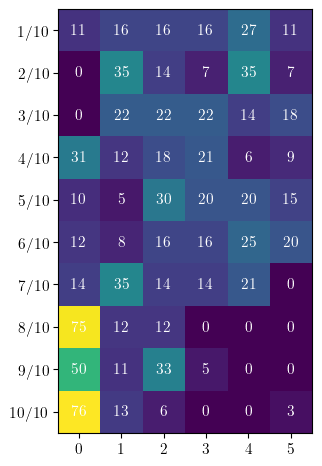

In [79]:
import matplotlib
import matplotlib.pyplot as plt

def density_histogram_plain(density):
  fig, ax = plt.subplots()
  im = ax.imshow(density)
  
  rewrites='0 1 2 3 4 5'.split(' ')
  successful_samples = [ f'{i+1}/10' for i in range(10) ]
  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(rewrites)), labels=rewrites)
  ax.set_yticks(np.arange(len(successful_samples)), labels=successful_samples)
  
  # Rotate the tick labels and set their alignment.
  #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  
  # Loop over data dimensions and create text annotations.
  for i in range(len(successful_samples)):
      for j in range(len(rewrites)):
          text = ax.text(j, i, density[i, j], ha="center", va="center", color="w")
  
  #ax.set_title("Density of rewrites required vs solution rate")
  fig.tight_layout()
  return plt

latex_pdf_graphic = {
  "pgf.texsystem": "pdflatex",
  'font.family': 'serif',
  'font.size' : 11,
  'text.usetex': True,
  'pgf.rcfonts': False,
}

# https://matplotlib.org/stable/api/matplotlib_configuration_api.html ??
with matplotlib.rc_context():
  matplotlib.rcParams.update(latex_pdf_graphic)
  plt = density_histogram_plain(density)  
  plt.show()

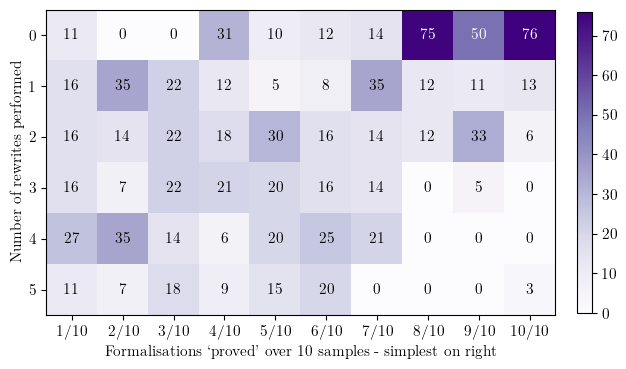

In [78]:
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def make_histogram(density, plt):
  fig, ax = plt.subplots()
  im = ax.imshow(density.T,  cmap='Purples')
  
  rewrites='0 1 2 3 4 5'.split(' ')
  successful_samples = [ f'{i+1}/10' for i in range(10) ]
  # Show all ticks and label them with the respective list entries
  ax.set_yticks(np.arange(len(rewrites)), labels=rewrites)
  ax.set_xticks(np.arange(len(successful_samples)), labels=successful_samples)
  
  ax.set_xlabel("Formalisations `proved' over 10 samples - simplest on right")
  ax.set_ylabel("Number of rewrites performed")
  
  # Rotate the tick labels and set their alignment.
  #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  
  cbar = fig.colorbar(im, fraction=0.046*0.6, pad=0.04) #  **cbar_kw ax=ax, 
  #cbar = plt.colorbar(im, fraction=0.046, pad=0.04) #  **cbar_kw ax=ax, 
  cbar.ax.set_ylabel("% proved at this rewrite step", rotation=-90, va="bottom")
  
  # Loop over data dimensions and create text annotations.
  for i in range(len(successful_samples)):
      for j in range(len(rewrites)):
          text = ax.text(i, j, density[i, j], ha="center", va="center", 
                         #color="w")
                         color="w" if density[i,j]>40 else 'k')
  
  #ax.spines[:].set_visible(False)
  
  #ax.set_title("Density of rewrites required vs solution rate")
  fig.tight_layout()
  return plt

with matplotlib.rc_context():
  matplotlib.rcParams.update(latex_pdf_graphic)
  plt = make_histogram(density, plt)
  plt.savefig('./experiments/formalisation_heatmap.pdf', 
              bbox_inches='tight', pad_inches=0.1,
             )
  plt.show()
  plt.close('all')


In [70]:
NOPE
#https://blog.timodenk.com/exporting-matplotlib-plots-to-latex/
import matplotlib
%matplotlib.use("pgf")
matplotlib.rcParams.update({
  "pgf.texsystem": "pdflatex",
  'font.family': 'serif',
  'font.size' : 11,
  'text.usetex': True,
  'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
plt = make_histogram(plt)
plt.savefig('./experiments/formalisation_heatmap.pgf')
plt.close('all')
%matplotlib inline

In [262]:
for exp_name in [ 'norewrites', '1rewrite', 'norewrites-manywordplay', '1rewrite-manywordplay', '1rewrite-manywordplay-guessdef']:
  rewrite_last_check=0 if 'norewrites' in exp_name else 1
  solves = get_solves_matrix(name=exp_name, split='train', rewrite_last_check=rewrite_last_check)  
  score_counts = get_scores_counts(solves)
  #print(f"{exp_name:s}\n{score_counts}") # .flatten()
  print(f"{exp_name:s}\n{score_counts[:,-1:].flatten()} = {score_counts[:,-1:].sum()}")   

norewrites
[ 1. 99.] = 100.0
1rewrite
[ 0.3  0.9 98.8] = 100.0
norewrites-manywordplay
[ 1.1 98.9] = 100.0
1rewrite-manywordplay
[ 1.3  1.2 97.5] = 100.0
1rewrite-manywordplay-guessdef
[ 2.7  1.9 95.4] = 100.0


In [5]:
import numpy as np
def get_confidence_intervals(pct, n, z=1.0, name=''):  #  z=1.96 for 95% confidence, z=1.65 for 90% conf
  p = pct/100.
  SE = np.sqrt(p*(1.-p)/n)
  ME = z*SE
  ME*=100.
  print(f"{pct=:6.1f}% +/- {ME:4.1f}% : {name}")

c_test = 26157
get_confidence_intervals(3.6, c_test, name='Julia cryptonite test - whole set')
get_confidence_intervals(8.6, c_test, name='Julia enum cryptonite test - whole set')

get_confidence_intervals(4.9, c_test, name='T5 cryptonite test - whole set')
get_confidence_intervals(7.6, c_test, name='T5 enum cryptonite test - whole set')

get_confidence_intervals(3.0, 1000, name='Gemini cryptonite test')
get_confidence_intervals(14.3, 1000, name='LLaMa 3 cryptonite test')

get_confidence_intervals(25.0, 1000, name='LLaMa 3 cryptonite test - a check') 

get_confidence_intervals(31.0, 200, name='Formaliser cryptonite test')

pct=   3.6% +/-  0.1% : Julia cryptonite test - whole set
pct=   8.6% +/-  0.2% : Julia enum cryptonite test - whole set
pct=   4.9% +/-  0.1% : T5 cryptonite test - whole set
pct=   7.6% +/-  0.2% : T5 enum cryptonite test - whole set
pct=   3.0% +/-  0.5% : Gemini cryptonite test
pct=  14.3% +/-  1.1% : LLaMa 3 cryptonite test
pct=  25.0% +/-  1.4% : LLaMa 3 cryptonite test
pct=  31.0% +/-  3.3% : Formaliser cryptonite test


### Runs for Test Hinting Effectiveness

* Essentially for the ICML Workshop : AI for Math

In [321]:
## Original case (copied down from cell above)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train', samples=10, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_with_hints', samples=2, examples=100)

#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train-flash', samples=2, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train-flash', samples=10, examples=100)

## NB: REVERT ICML changes in  debug_when_failed
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_no_hint', samples=2, examples=10)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_no_hint', samples=10, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_no_hint2', samples=10, examples=100)

#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train-flash_no_hint2', samples=10, examples=100)

## NB: REVERT ICML changes in  debug_when_failed
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_one_err', samples=2, examples=2)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_one_err', samples=10, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_one_err2', samples=2, examples=100)
#run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train_one_err2', samples=10, examples=100)

run_experiment('5rewrites-manywordplay-usewordplay', wordplay_train, shuffled_idx_wordplay_train, 'train-flash_one_err2', samples=10, examples=100)
## NB: REVERT ICML changes in  debug_when_failed

Starting with 0/1000 done
idx.iter=   0.00 :    1/1    success=100.00% ( 8.25s/iter ETA:2024-06-10 20:51:20 +08)
idx.iter=   1.00 :    1/2    success=50.00% ( 8.70s/iter ETA:2024-06-10 20:58:57 +08)
idx.iter=   2.00 :    2/3    success=66.67% ( 6.41s/iter ETA:2024-06-10 20:20:47 +08)
idx.iter=   3.00 :    3/4    success=75.00% ( 5.18s/iter ETA:2024-06-10 20:00:13 +08)
idx.iter=   4.00 :    3/5    success=60.00% ( 6.05s/iter ETA:2024-06-10 20:14:45 +08)
idx.iter=   5.00 :    3/6    success=50.00% ( 7.33s/iter ETA:2024-06-10 20:36:08 +08)
idx.iter=   6.00 :    3/7    success=42.86% ( 8.14s/iter ETA:2024-06-10 20:49:33 +08)
idx.iter=   7.00 :    3/8    success=37.50% ( 8.45s/iter ETA:2024-06-10 20:54:40 +08)
idx.iter=   8.00 :    4/9    success=44.44% ( 7.95s/iter ETA:2024-06-10 20:46:23 +08)
idx.iter=   9.00 :    4/10   success=40.00% ( 8.19s/iter ETA:2024-06-10 20:50:19 +08)
idx.iter=  10.00 :    4/11   success=36.36% ( 8.61s/iter ETA:2024-06-10 20:57:21 +08)
idx.iter=  11.00 :    4/12 

In [322]:
exp_name='5rewrites-manywordplay-usewordplay'
score_totals_arr=[]
for split in [ 'train_one_err',  'train_no_hint',  'train', 
               'train_one_err2', 'train_no_hint2', 'train_with_hints',  
               'train-flash_one_err2', 'train-flash_no_hint2', 'train-flash', 
             ]:
  solves = get_solves_matrix(name=exp_name, split=split, rewrite_last_check=5)
  score_counts = get_scores_counts(solves)
  #print(f"{exp_name:s}\n{score_counts}") # .flatten()
  score_totals=score_counts[:,-1:].flatten()
  print(f"{exp_name:s} : {split:s}\n  {score_totals} = {score_totals.sum()}")   
  print(f"    {solves[30]=}")
  score_totals_arr.append(score_totals)

5rewrites-manywordplay-usewordplay : train_one_err
  [ 2.9  1.7  1.5  1.3  1.6  1.3 89.7] = 100.0
    solves[30]=[1, -1, -1, -1, 0, -1, -1, -1, -1, -1]
5rewrites-manywordplay-usewordplay : train_no_hint
  [ 2.3  1.8  2.5  2.1  1.4  2.  87.9] = 100.0
    solves[30]=[-1, -1, 2, -1, -1, -1, 0, -1, -1, -1]
5rewrites-manywordplay-usewordplay : train
  [ 5.7  3.3  3.8  2.8  2.9  2.  79.5] = 100.0
    solves[30]=[-1, 1, -1, 1, 0, -1, 4, 4, 0, 1]
5rewrites-manywordplay-usewordplay : train_one_err2
  [ 6.7  2.1  3.2  2.5  2.5  2.3 80.7] = 100.0
    solves[30]=[1, 0, 3, -1, -1, 2, 0, -1, 2, 4]
5rewrites-manywordplay-usewordplay : train_no_hint2
  [ 5.8  3.1  4.4  3.5  2.4  2.4 78.4] = 100.0
    solves[30]=[0, -1, -1, -1, -1, -1, 0, 2, 2, 0]
5rewrites-manywordplay-usewordplay : train_with_hints
  [ 6.   4.5  4.5  2.   0.5  1.5 81. ] = 100.0
    solves[30]=[-1, -1]
5rewrites-manywordplay-usewordplay : train-flash_one_err2
  [19.7  4.5  1.8  2.1  1.1  0.5 70.3] = 100.0
    solves[30]=[0, 0, 0, 0, 0

In [ ]:
## Submitted to workshop:  (includes adjustment for first-draft limited precision)
# Single error &  5.9 &  1.7 &  1.5 &  1.3 & 1.6 & 1.3 \\
# Multi-error  &  5.5 &  1.8 &  2.5 &  2.1 & 1.4 & 2.0\\ 
# DSL Hinting  &  5.7 &  3.3 &  3.8 &  2.8 & 2.9 & 2.0 \\

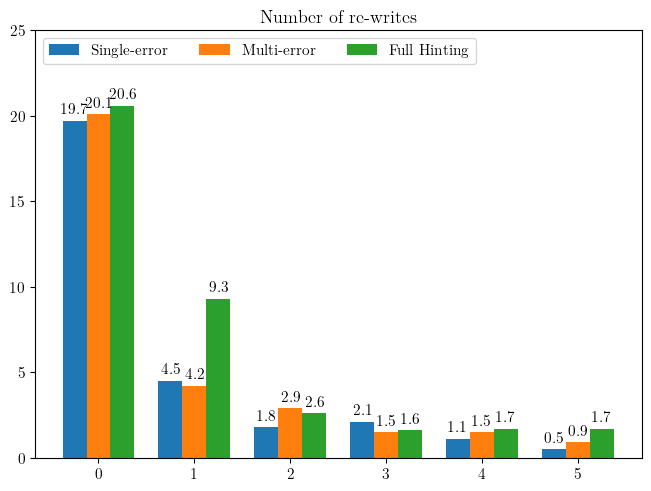

In [325]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
width = 0.25  # the width of the bars
multiplier = 0

labels= [ 'Single-error', 'Multi-error', 'Full Hinting',  ]
x = np.arange(6)  # the label locations

#for score_totals in score_totals_arr:
#  #plt.bar(height=score_totals, x=np.arange(0,7))
#  plt.bar(height=score_totals[:-1], x=np.arange(0,6))

fig, ax = plt.subplots(layout='constrained')

for idx, score_totals in enumerate(score_totals_arr[6:9]):
  offset = width * multiplier
  rects = ax.bar(x+offset, score_totals[:-1], width, label=labels[idx])
  ax.bar_label(rects, padding=3)
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% success')
ax.set_title('Number of re-writes')
ax.set_xticks(x+width, x)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 25.0)

plt.show()

### Generate for 1000 human wordplay to generate (hundreds of) python solutions

In [82]:
def run_solves_stealthily(name, data, shuffled_idx, split, samples_max=10, examples=10):  # examples is number of clues
  experiment_names_4 = '|stealthy_iter.div.2|'.split('|')
  if not name in experiment_names_4: 
    print(f"Bad experiment name={name}")
    return
  cnt, cnt_all = 0,0
  for idx in range(0, examples):
    cnt_all+=1
    log_file = log_file_name(name=name, split=split, idx=idx, iter=0) # Just check whether we've started at all on this one
    if os.path.isfile(log_file):
      cnt+=1
  print(f"Starting with {cnt}/{cnt_all} done")

  cnt_start, pos = cnt, 0
  t0=time.time()
  for idx in range(0, examples):
    log_file = log_file_name(name=name, split=split, idx=idx, iter=0)
    if os.path.isfile(log_file):
      continue # Skip this one : it's done already

    iter=0
    while iter<samples_max:
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      flog = open(log_file, 'w')
      question = data[shuffled_idx[idx]]
      if name in experiment_names_4:
        max_rewrites=5
        wordplay_rubric='./wordplay/manyshot_train.txt'

        clue = prompts.remove_enumeration_from(question['clue'])
        answer = question['answer']
        wordplay=question['wordplay']  # Must be there

        max_rewrites = 0 # Bad default
        if 'iter.div.2' in name:
          max_rewrites = iter//2  # This is a guess at the right kind of schedule
        
        success_rewrite = prompts.iteratively_answer(base_model, solver_config, 
                                    clue, answer=answer, pattern=question['enumeration'], wordplay=wordplay, 
                                    max_rewrites=max_rewrites, add_wordplay_hints=False, 
                                    wordplay_rubric=wordplay_rubric,
                                    flog=flog)
      flog.close()
      if success_rewrite>=0:
        pos+=1
        break
      #print(f"  idx.iter={idx:4d}.{iter:02d} {max_rewrites=}")
      iter+=1
      
    cnt+=1
    cnt_done = cnt-cnt_start
    elapsed  =(time.time()-t0)
    per_iter =elapsed/cnt_done
    remaining=per_iter*(cnt_all-cnt)
    eta_local=datetime.datetime.now(tz)+datetime.timedelta(seconds=remaining)
    print(f"idx.iter={idx:4d}.{iter:02d} : {pos:4d}/{cnt_done: <4d} success={100.*pos/cnt_done:5.2f}% "+
          f"({per_iter:5.2f}s/iter ETA:{eta_local.strftime('%Y-%m-%d %H:%M:%S %Z')})") # Remaining:{remaining:5.0f}s 

run_solves_stealthily('stealthy_iter.div.2', wordplay_train, shuffled_idx_wordplay_train, 'train', samples_max=10, examples=1000)
"DONE"

Starting with 1000/1000 done


'DONE'

In [84]:
wordplay_val, shuffled_idx_wordplay_val = solver.dataset.get_wordplay_data_and_shuffle('val')
"DONE", shuffled_idx_wordplay_val[:5]

('DONE', [57, 99, 64, 186, 154])

In [85]:
run_solves_stealthily('stealthy_iter.div.2', wordplay_val, shuffled_idx_wordplay_val, 'val', samples_max=10, examples=100)
"DONE"

Starting with 100/100 done


'DONE'

### Gather the SUCCESS python segments into a dataset...

In [334]:
def gather_success_python(name='stealthy_iter.div.2', split='train', samples_max=10, examples=100):
  # Step 1:Go through idx, iter to find SUCCESS runs (and spit out list of unfinished ones)
  # Step 2: Go through the SUCCESS run itself to extract the python solution, and store the important info
  solutions=[]
  for idx in range(examples):
    iter, found=0, False
    while iter<samples_max:
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      if not os.path.isfile(log_file):
        # We ran out of iters for this idx - but iter<samples_max : This is unfinished!
        print(f"Unfinished solution attempt: {log_file}")
        break 
      success_rewrite=-1
      with open(log_file, 'r') as fin:
        for line in fin.readlines():
          if "SUCCESS!" in line and "#REWRITE#" in line:
            # flog.write(f"\n#REWRITE#:{rewrite:d}:SUCCESS!\n")
            _, success_rewrite, _ = line.split(':')
            #success_rewrite=int(success_rewrite)
            found=True
      if found:
        started, py=False, []
        with open(log_file, 'r') as fin:
          for line in fin.readlines():
            if started:
              if line.startswith('#END#'):
                break
              py.append(line)
            if not started and f"#REWRITE#:{success_rewrite}:RESPONSE:(PY)::" in line:
              started=True
        #solves_idx.append(success_rewrite)
        solutions.append(dict(
          idx=idx, iter=iter, success_rewrite=success_rewrite,
          py=''.join(py),
        ))
        break
      iter+=1
  return solutions      
solutions_val = gather_success_python('stealthy_iter.div.2', split='val', samples_max=10, examples=100)
len(solutions_val)

42

In [335]:
solutions_train = gather_success_python('stealthy_iter.div.2', split='train', samples_max=10, examples=1000)
print(solutions_train[0]['py'])
print(len(solutions_train))

def proof(answer="TOUCH", clue="Drop Tory leader? That’s a sore point!", pattern='5'):
  """
  definition: {Drop} Tory leader? That’s a sore point!
  wordplay: T[ory] (leader) + OUCH (that’s a sore point!)
  """
  assert is_synonym("drop", "TOUCH", pattern='5')
  assert action_type("leader", Action.INITIALS)
  assert "T"+"OUCH"=="TOUCH"
  assert is_synonym("that’s a sore point!", "OUCH!") # corrected the wordplay


452


In [82]:
import pandas as pd
from datasets import Dataset, DatasetDict
os.makedirs('./datasets', exist_ok=True)

In [336]:
ver='2024-05-19'
def save_solutions_as_dataset(solutions, split):
  print( solutions[0] )
  # Save the dataset to disk
  Dataset.from_pandas(pd.DataFrame(solutions)).to_json(f'./datasets/solutions_{ver}_{split}.json')

save_solutions_as_dataset(solutions_train, 'train')
save_solutions_as_dataset(solutions_val, 'val')
"DONE"

{'idx': 1, 'iter': 8, 'success_rewrite': '3', 'py': 'def proof(answer="TOUCH", clue="Drop Tory leader? That’s a sore point!", pattern=\'5\'):\n  """\n  definition: {Drop} Tory leader? That’s a sore point!\n  wordplay: T[ory] (leader) + OUCH (that’s a sore point!)\n  """\n  assert is_synonym("drop", "TOUCH", pattern=\'5\')\n  assert action_type("leader", Action.INITIALS)\n  assert "T"+"OUCH"=="TOUCH"\n  assert is_synonym("that’s a sore point!", "OUCH!") # corrected the wordplay\n\n'}


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

{'idx': 0, 'iter': 0, 'success_rewrite': '0', 'py': 'def proof(answer="SHADDOCK", clue="We have fruit and fish by the harbour", pattern=\'8\'):\n  """\n  definition: We have {fruit} and fish by the harbour\n  wordplay: SHAD (fish) by the DOCK (harbour)\n  """\n  assert is_synonym("fruit", "SHADDOCK", pattern=\'8\')\n  assert is_synonym("fish", "SHAD")\n  assert is_synonym("by the harbour", "DOCK")\n  assert "SHAD"+"DOCK" == "SHADDOCK"\n\n'}


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

'DONE'

## Try to prove answer&candidate from wordplays saved from LLaMa

* Essentially for the ICML Workshop : Cognitive LLMs

In [12]:
#import solver.dataset
#definitions_found = solver.dataset.read_log_results([
#  './experiments/definitions/reddragonai_transformed_definitions_wraptokens_model_3_epochs_19_05_24/val_2024-05-28_17-57-23.log',
#])
#len(definitions_found)

In [15]:
import solver.dataset
wordplays_found = solver.dataset.read_log_results([
  #'./experiments/wordplay/reddragonai_transformed_wordplay_wraptokens_model_3_epochs_19_05_24/val_2024-05-29_06-35-33.log',
  #'./experiments/wordplay/reddragonai_transformed_wordplay_wraptokens_model_3_epochs_19_05_24/val_2024-05-29_06-50-10.log',
  #'./experiments/wordplay/reddragonai_transformed_wordplay_wraptokens_model_3_epochs_19_05_24/val_2024-05-29_09-15-25.log', # has clue_with_def
  # ICML cognitive orig # 5 wordplays each 
  #'./experiments/wordplay/reddragonai_transformed_wordplay_wraptokens_model_3_epochs_19_05_24/val_2024-05-30_19-08-38.log', 
  # ICML cognitive redo (def+wordplay generation)
  './experiments/wordplay/._llama3-it_def_and_wordplay_guesser_4_epoch_noex/val_2024-06-25_16-41-55.log',
])
len(wordplays_found)  # Each entry has an array of result dicts in it...

282

In [16]:
#wordplays_found[0]
wordplays_found[91]

[{'answer': 'TRIPE',
  'candidate': 0,
  'clue': 'Son out of line? Rubbish!',
  'clue_with_def': 'son out of line? {rubbish}!',
  'is_gold': True,
  'pattern': '5',
  'wordplay': 'T (son) + R (out of) + IPE (line)'},
 {'answer': 'DODGY',
  'candidate': 1,
  'clue': 'Son out of line? Rubbish!',
  'clue_with_def': 'son out of line? {rubbish}!',
  'is_gold': False,
  'pattern': '5',
  'wordplay': 'D (son) + O (out) + DG (line)'},
 {'answer': 'TRIPE',
  'candidate': 0,
  'clue': 'Son out of line? Rubbish!',
  'clue_with_def': 'son out of line? {rubbish}!',
  'is_gold': True,
  'pattern': '5',
  'wordplay': 'T (son) + R (out of) + IPE (line)'},
 {'answer': 'DODGY',
  'candidate': 1,
  'clue': 'Son out of line? Rubbish!',
  'clue_with_def': 'son out of line? {rubbish}!',
  'is_gold': False,
  'pattern': '5',
  'wordplay': 'D (son) + O (out) + DG (line)'},
 {'answer': 'TRIPE',
  'candidate': 0,
  'clue': 'Son out of line? Rubbish!',
  'clue_with_def': 'son out of line? {rubbish}!',
  'is_gold

In [19]:
wordplay_val, shuffled_idx_wordplay_val = solver.dataset.get_wordplay_data_and_shuffle('val')
shuffled_idx_wordplay_val[:15]

[57, 99, 64, 186, 154, 151, 173, 264, 108, 113, 94, 243, 208, 156, 263]

In [20]:
# Go through the wordplays, running the prover for 'samples' iterations
start_wordplay_result='---#WORDPLAY_RESULT#---'

def run_wordplays_for_candidates(name, data, shuffled_idx, split, samples_max=10, examples=10):  # examples is number of wordplay arrays
  experiment_names_5 = '|wordplays_1_candidate|wordplays5_1_candidate|def-and-wordplays5|'.split('|')
  if not name in experiment_names_5: 
    print(f"Bad experiment name={name}")
    return
  cnt, cnt_all = 0,0  
  for idx in range(0, examples):
    cnt_all+=1
    log_file = log_file_name(name=name, split=split, idx=idx, iter=0) # Just check whether we've started at all on this one
    if os.path.isfile(log_file):
      cnt+=1
  print(f"Starting with {cnt}/{cnt_all} done")

  cnt_start, pos_g, pos_o = cnt, 0, 0  # pos_g=GOLD correct, pos_a=OTHER (non-GOLD) correct
  t0=time.time()
  for idx in range(0, examples):
    log_file = log_file_name(name=name, split=split, idx=idx, iter=0)
    if os.path.isfile(log_file):
      continue # Skip this one : it's done already

    iter=0
    while iter<samples_max:
      log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
      flog = open(log_file, 'w')
      question = data[shuffled_idx[idx]]
      if name in experiment_names_5:
        max_rewrites=5
        wordplay_rubric='./wordplay/manyshot_train.txt'

        #clue = prompts.remove_enumeration_from(question['clue'])
        for wordplay_example in wordplays_found[shuffled_idx[idx]]:
          clue_with_def=wordplay_example['clue_with_def']
          pattern = wordplay_example['pattern']
          answer = wordplay_example['answer']
          wordplay=wordplay_example['wordplay']

          max_rewrites = 5
          success_rewrite = prompts.iteratively_answer(base_model, solver_config, 
                                    clue_with_def, answer=answer, pattern=pattern, wordplay=wordplay, 
                                    max_rewrites=max_rewrites, add_wordplay_hints=False, 
                                    wordplay_rubric=wordplay_rubric,
                                    flog=flog)
          
          # NEED TO WRITE A RESULT of SOME KIND THAT'S DEPENDENT ON wordplay_example
          solver.dataset.write_log_result(flog, question['idx_shuffled'], question['idx_orig'], dict(
            success_rewrite=success_rewrite,
            **wordplay_example,
          ), start=start_wordplay_result)

          if success_rewrite>=0:
            if wordplay_example['is_gold']:
              pos_g+=1
            else:
              pos_o+=1
        #pos+=1

      flog.close()
      #  break
      #print(f"  idx.iter={idx:4d}.{iter:02d} {max_rewrites=}")
      iter+=1
      
    cnt+=1
    cnt_done = cnt-cnt_start
    elapsed  =(time.time()-t0)
    per_iter =elapsed/cnt_done
    remaining=per_iter*(cnt_all-cnt)
    eta_local=datetime.datetime.now(tz)+datetime.timedelta(seconds=remaining)
    print(f"idx.iter={idx:4d}.{iter:02d} : {pos_g+pos_o:4d}/{cnt_done: <4d} "+
          f"gold%={100.*pos_g/cnt_done:5.2f}% other%={100.*pos_o/cnt_done:5.2f}% "+
          f"({per_iter:5.2f}s/iter ETA:{eta_local.strftime('%Y-%m-%d %H:%M:%S %Z')})") # Remaining:{remaining:5.0f}s 
    
#run_wordplays_for_candidates('wordplays_1_candidate', wordplay_val, shuffled_idx_wordplay_val, 'val', samples_max=5, examples=2)
#run_wordplays_for_candidates('wordplays_1_candidate', wordplay_val, shuffled_idx_wordplay_val, 'val', samples_max=5, examples=100)
#run_wordplays_for_candidates('wordplays_1_candidate', wordplay_val, shuffled_idx_wordplay_val, 'val-flash', samples_max=5, examples=10)

shuffled_idx_wordplay_val_filtered = [ shuf for shuf in shuffled_idx_wordplay_val if shuf<len(wordplays_found) ]
# ICML Cognitive submission: = Gemini 1.0:
#run_wordplays_for_candidates('wordplays5_1_candidate', wordplay_val, shuffled_idx_wordplay_val_filtered, 'val-filtered', samples_max=1, examples=100)
# ICML Cognitive submission: = Gemini-Flash 1.5:
#run_wordplays_for_candidates('wordplays5_1_candidate', wordplay_val, shuffled_idx_wordplay_val_filtered, 'val-filtered-flash', samples_max=1, examples=100)
# ICML Cognitive submission: = Gemini-Flash 1.5:
run_wordplays_for_candidates('def-and-wordplays5', wordplay_val, shuffled_idx_wordplay_val_filtered, 'val-filtered-flash', samples_max=1, examples=100)
"DONE"  # gemini-1.0 = 200sec/iter, gemini-flash-1.5 = 120sec/iter

Starting with 100/100 done


'DONE'

In [20]:
#shuffled_idx_wordplay_val_filtered[:10]
shuffled_idx_wordplay_val_filtered[34:37]

[246, 105, 222]

In [30]:
# Now let's compute the percentage correct from the log-file itself
def get_solves_for_example(name, split, idx, max_candidates=2, debug=False):
  iter=0
  by_candidate=[ [] for _ in range(max_candidates) ]
  #print( max_candidates, by_candidate )
  while True:
    log_file = log_file_name(name=name, split=split, idx=idx, iter=iter)
    if not os.path.isfile(log_file):
      break # We ran out of iters for this idx
    overlaid = solver.dataset.read_log_results([log_file], start=start_wordplay_result)
    for idx_ex, wordplay_result_arr in overlaid.items():
      #assert idx_ex == idx
      for example in wordplay_result_arr:
        if debug:
          print(example)
        candidate=example.get('candidate', 0 if example['is_gold'] else 1)
        success_rewrite = example['success_rewrite']
        by_candidate[candidate].append(success_rewrite)
    iter+=1
  return by_candidate
  
def get_solves_matrices_for_candidates(name, split, max_candidates=2):
  solves_by_candidate=[]
  idx=0
  while True:
    by_candidate = get_solves_for_example(name, split, idx, max_candidates=max_candidates)
    if len(by_candidate[0])==0:
      break # We didn't find the first file for this idx    
    solves_by_candidate.append(by_candidate)  # at [idx]
    idx+=1
  return solves_by_candidate

# ICML Cognitive submission: (gemini 1.0 pro) - val not filtered?  Maybe in error somehow...
#solves_by_candidate = get_solves_matrices_for_candidates(name='wordplays_1_candidate', split='val')

# ICML Cognitive submission: (gemini 1.0 pro)
#solves_by_candidate = get_solves_matrices_for_candidates(name='wordplays5_1_candidate', split='val-filtered')
# ICML Cognitive addition: ( Same, but with flash )
#solves_by_candidate = get_solves_matrices_for_candidates(name='wordplays5_1_candidate', split='val-filtered-flash')
# ICML Cognitive addition (with def+word):
solves_by_candidate = get_solves_matrices_for_candidates(name='def-and-wordplays5', split='val-filtered-flash')

len(solves_by_candidate), solves_by_candidate[20] #  20 !
#len(solves_by_candidate), solves_by_candidate[11] #  20 !

(100, [[-1, -1, -1, -1, -1], [0, 0, -1, -1, -1]])

In [31]:
#idx=20
#get_solves_for_example(name='wordplays_1_candidate', split='val', idx=idx, max_candidates=2, debug=True)

In [32]:
def score_solves_by_candidate(solves_by_candidate, fn):
  win_0,win_1,draw,cnt = 0,0,0,0
  for s in solves_by_candidate:
    scores=[ 0 for _ in range(len(s)) ]
    for i, side in enumerate(s):
      scores[i] = fn(side)
    score = scores[0] - scores[1]
    if score>0: win_0+=1
    elif score<0: win_1+=1
    else: draw+=1
    cnt+=1
  score_arr = win_0/cnt, draw/cnt, win_1/cnt
  print(f"& {score_arr[0]*100:2.0f}\% & {score_arr[1]*100:2.0f}\% & {score_arr[2]*100:2.0f}\% \\")
  return score_arr
def count_solves(side):
  return sum([ (1 if run>-1 else 0) for run in side ])
def fastest_solve(side):
  #return sum([ (5-run if run>-1 else 0) for run in side ])
  return -min([ (run if run>-1 else 6) for run in side+[-1] ] )
def mean_solve(side):
  return sum([ (6-run if run>-1 else 0) for run in side ])
  
score_arr=score_solves_by_candidate(solves_by_candidate, count_solves) 
score_arr=score_solves_by_candidate(solves_by_candidate, fastest_solve)
score_arr=score_solves_by_candidate(solves_by_candidate, mean_solve)   

# Original ICML Cognitive submission (also...)  WHAT IS THE DIFFERENCE?
# 500 files done...
# wordplays_1_candidate', split='val' gemini-1.0-pro
# & 27\% & 61\% & 12\% \
# & 29\% & 55\% & 16\% \
# & 32\% & 52\% & 16\% \
#   WILL KILL THIS ONE for -camera-ready

# Original ICML Cognitive submission... Gemini-1.0-Pro
# 'wordplays5_1_candidate', split='val-filtered' (confirmed)
# & 38\% & 59\% &  3\% \
# & 38\% & 56\% &  6\% \
# & 38\% & 56\% &  6\% \
#   Here we did llama def (no ans), then llama wordplay (with def+ans)
#   Keep this in -camera-ready

& 40\% & 55\% &  5\% \
& 40\% & 55\% &  5\% \
& 42\% & 53\% &  5\% \


In [33]:
# 'wordplays5_1_candidate', split='val-filtered-flash' (confirmed)
# & 21\% & 78\% &  1\% \
# & 22\% & 75\% &  3\% \
# & 24\% & 72\% &  4\% \
#   Here we did llama def (no ans), then llama wordplay (with def+ans)
# Puzzling : slightly better ratio, but perhaps 1.5-flash is better at coding / doesn't fake it?

# 'def-and-wordplays5', split='val-filtered-flash' (confirmed)
# & 40\% & 55\% &  5\% \
# & 40\% & 55\% &  5\% \
# & 42\% & 53\% &  5\% \
# Good result for flash-1.5, using diverse llama (using answer => def+word)
#   Add this to -camera-ready